In [1]:
from google.colab import drive
from pathlib import Path
from collections import deque
import os, json, random, warnings
import matplotlib.pyplot as plt
import cv2
import pandas as pd
import numpy as np

# tensorflow for number predictions
import tensorflow as tf
tf.config.run_functions_eagerly(True) # some magic that is needed (thanks, stackoverflow), however it annoys with a warning
warnings.filterwarnings("ignore", category=UserWarning) # a big hammer
warnings.filterwarnings("ignore", category=FutureWarning) # a big hammer
from tensorflow.keras import layers, models

# detectron for mask-rcnn
# this may want to restart the environment
!pip install 'git+https://github.com/facebookresearch/detectron2.git'
# import torch
# import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.engine import DefaultTrainer
from detectron2.data.datasets import register_coco_instances
from detectron2.utils.visualizer import ColorMode


  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-lbwz9oi1
  Running command git clone -q https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-lbwz9oi1


In [2]:
# data is on my drive
drive.mount('/content/drive')
os.chdir("/content/drive/My Drive/MVI/data")

Mounted at /content/drive


In [3]:
# some variables

SUDOKU_SIZE = 9   # used in solver and number extraction
DEBUG = True      # used in solver (later it's set to False)
MNIST_SIZE = 28   # used in mnist training and number extration

# Sudoku solver

## Backjumping sudoku solver

In [4]:
# size of the puzzle, sadly changing it now won't allow us to process larger puzzles (itSqa() needs to be updated), note: variables moved elsewhere
# SUDOKU_SIZE = 9
# DEBUG = True

# one "box" for number
class SudokuNode:
	
  def __init__(self, other = None):
    # number written in here
    self.number = 0
    # numbers that can be here
    self.opt = set([i+1 for i in range(9)])
    # number in a decidion tree
    self.jmp = -1
    # info about line, col, sqa
    self.info = [-1 for i in range(3)]

    if other is None:
      return

    self.number = other.number
    self.opt = other.opt.copy()
    self.jmp = other.jmp

  def __eq__(self, other):
    return (self.info[0] == other.info[0] and self.info[1] == other.info[1])


  def show(self):
    print(self.number, end='')

# class end


# sudoku board
class SudokuBoard:

  def __init__(self):
    # we store the board here
    self.board = [SudokuNode() for i in range(SUDOKU_SIZE**2)]


  # get sudoku from array of numbers (sudoku in 2d)
  def init(self, sudoku):

    # copy input into board
    for i in range(len(sudoku)):
      self.board[i].number = int(sudoku[i])
      # if we have a solid number, remove optionals 
      if self.board[i].number != 0:
        self.board[i].opt = set()

    # set info
    for f in range(3):
      for w in range(SUDOKU_SIZE):
        for i in range(SUDOKU_SIZE):
          index = self.iterator(f,w,i)
          self.board[index].info[f] = w

	# tries to eliminate some options, does the first checking, if the sudoku is solvable
  def prepare(self):
    again = True
    while(again):
      again = False
      # check all tiles
      for x in range(SUDOKU_SIZE**2):
        nodeX = self.board[x]
        # if the number is set
        if nodeX.number != 0:
          # then check all iterators
          for f in range(3):
            # that each element is different, or return false
            for i in range(SUDOKU_SIZE):
              index = self.iterator(f ,nodeX.info[f] , i)
              # do not check yourself
              if index == x:
                continue
              nodeO = self.board[index]
              # check for same number in the same group
              if nodeX.number == nodeO.number:
                return False
              # we can erase some opt numbers and if their size is 1, we can assign the only number and run this function again
              try:
                nodeO.opt.remove(nodeX.number)
              except KeyError:
                pass
                 
              if len(nodeO.opt) == 1:
                nodeO.number = nodeO.opt.pop()
                again = True;			
              
          #it end
        #if end
      #main for end	
    #while end
    return True


  # run BJ to solve the sudoku
  def solve(self):

    # nodes to decide
    dec = []

    for x in self.board:
      if x.number == 0:
        dec.append(x)

    dec.sort(key = lambda x: len(x.opt))

    for i in range(len(dec)):
      dec[i].jmp = i

    if DEBUG:
      print("decsize=", len(dec))
      for n in dec:
        print(n.jmp, " ", n.opt)

    r = self.runSolve(dec,0)
    return (len(r) == 0)



  # use backjumping to solve the sudoku
  # array of undecided nodes, number of current node
  def runSolve(self, dec, i):
      
    if(i == len(dec)):
      return set() # ende
		
    # current node
    curr = dec[i]
    # return value
    ret = set()
    # collision with other node, we "need" the biggest one possible
    collision = set()
    numberOk = False

    for d in curr.opt:

      if DEBUG:
        print("trying",d,"for jmp",i, end='')

      curr.number = d
      numberOk = True

      # check, if the number is OK, by cycling over his neighbours
      for f in range(3):
        for j in range(SUDOKU_SIZE):
          index = self.iterator(f, curr.info[f], j)
          if self.board[index] == curr:
            continue # not myself

          o = self.board[index]

          if(o.number == curr.number):
            if DEBUG:
              print(" >> coll", o.jmp, "!", end='')

            collision.add(o.jmp)
            numberOk = False
            # even now we need to check all neighbours so we don't skip a potencional choice
      # for end

      if DEBUG:
        print()

      if not numberOk:
        continue

      if DEBUG:
        print("running solve from i=",i,", n=",curr.number)

      # run next
      ret = self.runSolve(dec, i+1)

      if DEBUG:
        print("got: ","i=",i,", ret=", ret)

      # we are done
      if len(ret) == 0:
        if DEBUG:
          print("returning, empty ret from i=",i)	
        return ret

      # else find max of the set (cries in python)      
      # the biggest number in ret is telling us to where to backjump
      max = -1
      for r in ret:
        if r > max:
          max = r
          
      # backjump here
      if max == i:
        ret.remove(i)
        collision = set.union(ret,collision) # merge with our collisions
        continue
      # else jump away
      else:
        curr.number = 0
        if DEBUG:
          print("returning ret=", ret, ", from i =",i)
        return ret

    # if we are here, it means, that we could not assign a number
    if DEBUG:
      print("returning coll=",str(collision),", from i =",i)
    curr.number = 0;
    return collision



  # this helps us with 1d -> 2d conversion
  def at(self, x, y):
    return (SUDOKU_SIZE*x+y)

  # iterator for iterators
  # f - 0 1 2 - line, col, sqa
  # w - 1st param - which type
  # i - 2nd param - index
  def iterator(self, f, w, i):

    if f == 0:
      return self.itLine(w,i)
    if f == 1:
      return self.itCol(w,i)
    if f == 2:
      return self.itSqa(w,i) 
    # we should not be here
    raise ValueError("f out of founds <0,2> : " + str(f))


  # iterator for lines
  def itLine(self, line, index):
    return (line*SUDOKU_SIZE+index)


  # iterator for columns
  def itCol(self, coll, index):
    return (index*SUDOKU_SIZE+coll)


  # iterator for squares - 
  # 0 1 2 
  # 3 4 5 
  # 6 7 8
  # some magic numbers are here, to summon them, you need a unicorn blood, frog's eye, feather of a hawk and a MS excel
  def itSqa(self, sqa, index):

    id3 = int(index/3)
    sd3 = int(sqa/3)
    id3*=6
    sd3*=18
    return (sd3+index+id3+3*sqa)



  # prints out the sudoku
  def show(self):
    print("board:")
    for i in range(SUDOKU_SIZE):
      for j in range(SUDOKU_SIZE):
        self.board[self.at(i,j)].show()
        if ((j+1) % 3 == 0):
          print("|", end='')
        else:
          print(" ", end='')
      # j end
      print()
      if ((i+1) % 3 == 0):
        for t in range(SUDOKU_SIZE+2):
          print("-", end='')
        print() #nl
  

  # additional info
  def info(self):
    print("info about choices in nodes:")
    for i in range(SUDOKU_SIZE):
      for j in range(SUDOKU_SIZE):
        print(len(self.board[self.at(i,j)].opt), end='')
        if ((j+1) % 3 == 0):
          print('|', end='')
        else:
          print(' ', end='')
      #j end
      print()
      if ((i+1) % 3 == 0):
        for t in range(SUDOKU_SIZE+2):
          print("-", end='')
        print() #nl


# class end

## Example usage of the solver

In [ ]:
sudoku = "006040097040730010017092030600070080105060903020010006050980160090056070860020300"
solver = SudokuBoard()
solver.init(sudoku)
print(solver.prepare())
print(solver.solve())
solver.show()

True
True
board:
3 8 6|5 4 1|2 9 7|
2 4 9|7 3 8|6 1 5|
5 1 7|6 9 2|4 3 8|
-----------
6 3 4|2 7 9|5 8 1|
1 7 5|8 6 4|9 2 3|
9 2 8|3 1 5|7 4 6|
-----------
7 5 2|9 8 3|1 6 4|
4 9 3|1 5 6|8 7 2|
8 6 1|4 2 7|3 5 9|
-----------


# Training model to recognize numbers

## Load and preprocess MNIST dataset

In [ ]:
# load mnist
(mnistTrainX, mnistTrainY), (mnistTestX, mnistTestY) = tf.keras.datasets.mnist.load_data()
# load empty image, that will replace zeros - our sudoku solver want's 0 as the "solve what is in there" value
empty = cv2.imread("empty.jpg", cv2.IMREAD_GRAYSCALE)
# set images to floats
mnistTrainX = mnistTrainX.astype("float32")
mnistTestX = mnistTestX.astype("float32")
# also try adding some random noice, for this split train x into clear and noisy
mnistTestXClear = mnistTestX.copy()

# replace zeros with "empty" and add noise
for i in range(len(mnistTrainY)):
  if mnistTrainY[i] == 0:
    mnistTrainX[i] = empty
  mnistTrainX[i] = mnistTrainX[i] + np.random.normal(0,11,empty.shape)
  
for i in range(len(mnistTestY)):
  if mnistTestY[i] == 0:
    mnistTestX[i] = empty
    mnistTestXClear[i] = empty
  mnistTestX[i] = mnistTestX[i] + np.random.normal(0,11,empty.shape)

# normalise images (0-255)
mnistTrainX /= 255
mnistTestX /= 255
mnistTestXClear /= 255

# expand dimensions
mnistTrainX = np.expand_dims(mnistTrainX, -1)
mnistTestX = np.expand_dims(mnistTestX, -1)
mnistTestXClear = np.expand_dims(mnistTestXClear, -1)

# one hot y
mnistTrainY = tf.keras.utils.to_categorical(mnistTrainY, 10)
mnistTestY = tf.keras.utils.to_categorical(mnistTestY, 10)

11501568/11490434 [==============================] - 0s 0us/step


## Define our model 

In [ ]:
# model is based on this kaggle notebook https://www.kaggle.com/cdeotte/25-million-images-0-99757-mnist/notebook

mnistModel = models.Sequential()
mnistModel.add(layers.Conv2D(32, kernel_size=3, activation="relu", input_shape=(28,28,1)))
mnistModel.add(layers.BatchNormalization())
mnistModel.add(layers.Conv2D(32, kernel_size=3, activation='relu'))
mnistModel.add(layers.BatchNormalization())
mnistModel.add(layers.Conv2D(32, kernel_size=5, strides=2, padding='same', activation='relu'))
mnistModel.add(layers.BatchNormalization())
mnistModel.add(layers.Dropout(0.4))
mnistModel.add(layers.Conv2D(64, kernel_size = 3, activation='relu'))
mnistModel.add(layers.BatchNormalization())
mnistModel.add(layers.Conv2D(64, kernel_size = 3, activation='relu'))
mnistModel.add(layers.BatchNormalization())
mnistModel.add(layers.Conv2D(64, kernel_size = 5, strides=2, padding='same', activation='relu'))
mnistModel.add(layers.BatchNormalization())
mnistModel.add(layers.Dropout(0.4))
mnistModel.add(layers.Conv2D(128, kernel_size = 4, activation='relu'))
mnistModel.add(layers.BatchNormalization())
mnistModel.add(layers.Flatten())
mnistModel.add(layers.Dropout(0.4))
mnistModel.add(layers.Dense(10, activation='softmax')) # 10 outputs

mnistModel.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

## Summary and training

In [ ]:
mnistModel.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 26, 26, 32)        320       
                                                                 
 batch_normalization_14 (Bat  (None, 26, 26, 32)       128       
 chNormalization)                                                
                                                                 
 conv2d_16 (Conv2D)          (None, 24, 24, 32)        9248      
                                                                 
 batch_normalization_15 (Bat  (None, 24, 24, 32)       128       
 chNormalization)                                                
                                                                 
 conv2d_17 (Conv2D)          (None, 12, 12, 32)        25632     
                                                                 
 batch_normalization_16 (Bat  (None, 12, 12, 32)      

In [ ]:
epochs = 45

mnistModelHistory = mnistModel.fit(mnistTrainX, mnistTrainY, epochs=epochs)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4527: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Epoch 1/45
1875/1875 [==============================] - 111s 59ms/step - loss: 0.1720 - accuracy: 0.9463
Epoch 2/45
1875/1875 [==============================] - 107s 57ms/step - loss: 0.0655 - accuracy: 0.9796
Epoch 3/45
1875/1875 [==============================] - 107s 57ms/step - loss: 0.0529 - accuracy: 0.9838
Epoch 4/45
1875/1875 [==============================] - 107s 57ms/step - loss: 0.0444 - accuracy: 0.9867
Epoch 5/45
1875/1875 [==============================] - 108s 57ms/step - loss: 0.0398 - accuracy: 0.9880
Epoch 6/45
1875/1875 [==============================] - 108s 57ms/step - loss: 0.0346 - accuracy: 0.9900
Epoch 7/45
1875/1875 [==============================] - 107s 57ms/step - loss: 0.0315 - accuracy: 0.9905
Epoch 8/45
1875/1875 [==============================] - 106s 57ms/step - loss: 0.0264 - accuracy: 0.9920
Epoch 9/45
1875/1875 [==============================] - 108s 58ms/step - loss: 0.0255 - accuracy: 0.9923
Epoch 10/45
1875/1875 [==============================] 

## Save and load

In [ ]:
mnistModel.save('mnistModel.model')

INFO:tensorflow:Assets written to: mnistModel.model/assets


In [5]:
mnistModel = models.load_model('mnistModel.model')

# Functions to extract numbers from sudoku grid

## The functions

In [33]:
# both moved else where
# MNIST_SIZE = 28
# SUDOKU_SIZE = 9

# converts 1d point to 2d
def to2D(index, xsize, ysize):
  return (index%ysize, int(index/xsize))

# takes 4 points from 'img' and makes them into a square of size 'to'
def extractImage(img, fromA, fromB, fromC, fromD, to):
  # why can't it be A,B,C,D? >:(
  pts1 = np.float32(
    [
     fromA,
     fromC,     
     fromD,
     fromB,
    ]
  )

  pts2 = np.float32(
    [
     [0,0],#A
     [0,to],#C
     [to,to],#D
     [to,0],#B
    ]
  )
  # transform
  transform = cv2.getPerspectiveTransform(pts1,pts2)
  ext = cv2.warpPerspective(img, transform, (to, to))
  # do some wild stuff to make it black n white
  return ext


# extract 81 numbers from the grid
def extractNumbers(img, show = False):
  nodes = []
  for i in range(SUDOKU_SIZE*SUDOKU_SIZE):
    dd = to2D(i,SUDOKU_SIZE,SUDOKU_SIZE)
    A = np.array([dd[0],dd[1]])*MNIST_SIZE
    B = np.array([dd[0]+1,dd[1]])*MNIST_SIZE
    C = np.array([dd[0],dd[1]+1])*MNIST_SIZE
    D = np.array([dd[0]+1, dd[1]+1])*MNIST_SIZE
    # get single digit and convert it to grayscale, invert colors (mnist is on black background) and normalise
    ext = extractImage(img, A, B, C, D, MNIST_SIZE)
    ext = 255-cv2.cvtColor(ext, cv2.COLOR_BGR2GRAY)
    if show:
      plt.imshow(ext, cmap='gray')
      plt.show()
    nodes.append(ext)
    
  # normalize, add last dimention and predict all
  nodes = np.array(nodes)
  nodes = nodes.astype("float32")
  nodes /= 255
  nodes = np.expand_dims(nodes, -1)
  preds = mnistModel.predict(nodes)
  #return nodes, [np.argmax(i) for i in preds]
  return [np.argmax(i) for i in preds]



## Try extraction from image

81/81 ok


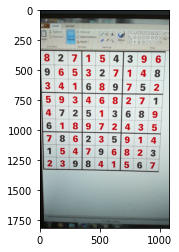

In [40]:
# load solved example sudoku to check if we loaded everything properly
img = cv2.imread("sud_example1.jpg")
goal = [8,2,7,1,5,4,3,9,6,9,6,5,3,2,7,1,4,8,3,4,1,6,8,9,7,5,2,5,9,3,4,6,8,2,7,1,4,7,2,5,1,3,6,8,9,6,1,8,9,7,2,4,3,5,7,8,6,2,3,5,9,1,4,1,5,4,7,9,6,8,2,3,2,3,9,8,4,1,5,6,7]
# points are known before
pts = np.float32(
    [[4, 339],
     [1043, 352],
     [35, 1316],
     [982, 1339]]
)
ext = extractImage(img, pts[0], pts[1], pts[2], pts[3], 252)
pre = extractNumbers(ext)
ok = 0
for i in range(len(goal)):
  if goal[i] == pre[i]:
    ok+=1

plt.imshow(img)
print(str(ok)+"/81 ok")



## Try solving uncomplete sudoku from image

[0, 2, 0, 0, 0, 4, 3, 0, 0, 9, 0, 0, 0, 2, 0, 0, 0, 8, 0, 0, 0, 6, 0, 9, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 7, 2, 5, 0, 3, 6, 8, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 0, 2, 0, 5, 0, 0, 0, 1, 0, 0, 0, 9, 0, 0, 0, 3, 0, 0, 9, 8, 0, 0, 0, 6, 0]
True
True
board:
8 2 7|1 5 4|3 9 6|
9 6 5|3 2 7|1 4 8|
3 4 1|6 8 9|7 5 2|
-----------
5 9 3|4 6 8|2 7 1|
4 7 2|5 1 3|6 8 9|
6 1 8|9 7 2|4 3 5|
-----------
7 8 6|2 3 5|9 1 4|
1 5 4|7 9 6|8 2 3|
2 3 9|8 4 1|5 6 7|
-----------


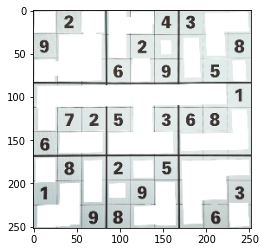

In [18]:
# try to load the same sudoku, bud unsolved
img = cv2.imread("sud_example2.jpg")
goal = [8,2,7,1,5,4,3,9,6,9,6,5,3,2,7,1,4,8,3,4,1,6,8,9,7,5,2,5,9,3,4,6,8,2,7,1,4,7,2,5,1,3,6,8,9,6,1,8,9,7,2,4,3,5,7,8,6,2,3,5,9,1,4,1,5,4,7,9,6,8,2,3,2,3,9,8,4,1,5,6,7]
# points are known before
pts = np.float32(
    [[4, 339],
     [1043, 352],
     [35, 1316],
     [982, 1339]]
)
ext = extractImage(img, pts[0], pts[1], pts[2], pts[3], 252)
sudoku = extractNumbers(ext)
print(sudoku)
plt.imshow(ext)
DEBUG = False
solver = SudokuBoard()
solver.init(sudoku)
print(solver.prepare())
print(solver.solve())
solver.show()


# Finding sudoku in image

## Train mask rcnn on sudoku dataset

In [11]:
# annotations are in coco json
# DatasetCatalog.clear()
# MetadataCatalog.clear()
register_coco_instances("mrcnnTrain", {}, "mrcnnTrain/labels.json", "mrcnnTrain")
register_coco_instances("mrcnnTest", {}, "mrcnnTest/labels.json", "mrcnnTest")


[01/18 08:55:45 d2.data.datasets.coco]: Loading mrcnnTrain/labels.json takes 1.61 seconds.
[01/18 08:55:46 d2.data.datasets.coco]: Loaded 160 images in COCO format from mrcnnTrain/labels.json
mrcnnTrain/image2.jpg


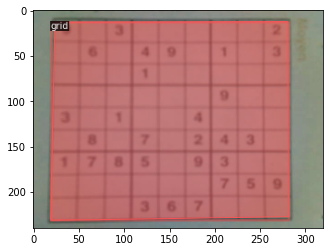

mrcnnTrain/image107.jpg


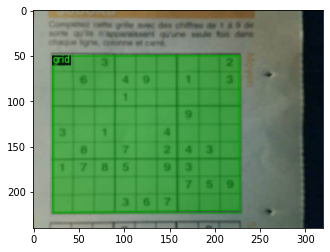

mrcnnTrain/image195.jpg


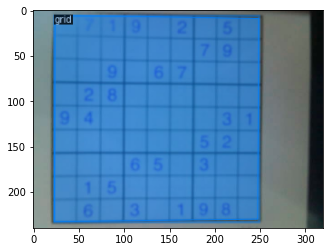

In [ ]:
# show some samples
catalogSet = "mrcnnTrain"
dataset_dicts = DatasetCatalog.get(catalogSet)
for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=MetadataCatalog.get(catalogSet), scale=0.5)
    out = visualizer.draw_dataset_dict(d)
    print(d["file_name"])
    plt.imshow(out.get_image()[:, :, ::-1])
    plt.show()

In [ ]:
# train model, follow detectron's tutorial
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("mrcnnTrain",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # get pretrained model
cfg.SOLVER.IMS_PER_BATCH = 2 # setup parameters
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 3000
cfg.SOLVER.STEPS = [] 
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 248   # (default is 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # there is only grid class (do not add background)
cfg.OUTPUT_DIR = "mrcnnModel"

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[01/17 18:05:25 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (2, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (2,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (1, 256, 1, 1) in

[01/17 18:05:26 d2.engine.train_loop]: Starting training from iteration 0
[01/17 18:05:35 d2.utils.events]:  eta: 0:19:47  iter: 19  total_loss: 1.641  loss_cls: 0.6808  loss_box_reg: 0.2051  loss_mask: 0.6945  loss_rpn_cls: 0.03874  loss_rpn_loc: 0.007858  time: 0.3877  data_time: 0.0177  lr: 4.9953e-06  max_mem: 2669M
[01/17 18:05:43 d2.utils.events]:  eta: 0:19:28  iter: 39  total_loss: 1.442  loss_cls: 0.5509  loss_box_reg: 0.2041  loss_mask: 0.6644  loss_rpn_cls: 0.0186  loss_rpn_loc: 0.00832  time: 0.3924  data_time: 0.0089  lr: 9.9902e-06  max_mem: 2669M
[01/17 18:05:51 d2.utils.events]:  eta: 0:19:33  iter: 59  total_loss: 1.196  loss_cls: 0.3636  loss_box_reg: 0.2093  loss_mask: 0.5993  loss_rpn_cls: 0.02262  loss_rpn_loc: 0.009786  time: 0.3982  data_time: 0.0094  lr: 1.4985e-05  max_mem: 2669M
[01/17 18:05:59 d2.utils.events]:  eta: 0:19:36  iter: 79  total_loss: 1.006  loss_cls: 0.249  loss_box_reg: 0.2026  loss_mask: 0.5294  loss_rpn_cls: 0.01007  loss_rpn_loc: 0.01083  ti

In [ ]:
# get predictor right after training
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

## Load trained model

In [7]:
# load predictor from checkpoint
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.OUTPUT_DIR = "mrcnnModel"
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set a custom testing threshold
cfg.MODEL.DEVICE='cpu'
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1
predictor = DefaultPredictor(cfg)

## Preview some predictions

[01/18 08:57:59 d2.data.datasets.coco]: Loaded 40 images in COCO format from mrcnnTest/labels.json


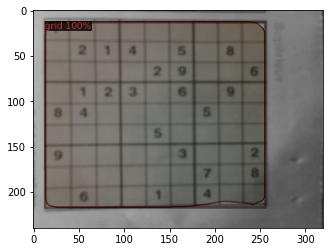

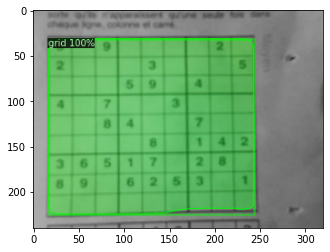

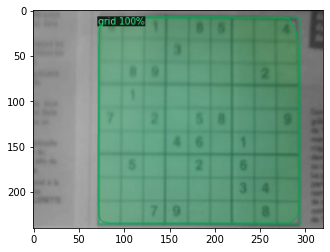

In [ ]:
# preview some predictions
catalogSet = "mrcnnTest"
dataset_dicts = DatasetCatalog.get(catalogSet)
for d in random.sample(dataset_dicts, 3):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=MetadataCatalog.get(catalogSet), 
                   scale=0.5, 
                   instance_mode=ColorMode.IMAGE_BW
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.imshow(out.get_image()[:, :, ::-1])
    plt.show()

## Getting the actual corners of sudoku

In [16]:
# the sudoku can be skewed, we try to find the corners in the mask by proximity to bounding box 
# finds nearest points on mask starting from the over-box corners
class BFSFinder:

  # the mask is a boolean array with its shape being the same as the picture shape, true means that there is a sudoku and we are trying to find it
  def __init__(self, mask):
    self.mask = mask

  # run bfs to find true
  def start(self, start):
    qu = deque() # queue
    vis = set() # visited
    qu.append(start)
    vis.add(self.hash(start))
    while(len(qu)):
      curr = qu.popleft()

      # found nearest
      if self.at(curr):
        return curr

      next = [i for i in self.nei(curr) if (self.hash(i) not in vis) and (self.inrange(i))]
      vis.update([self.hash(i) for i in next ])
      qu.extend(next)


    return None # error

  # returns neigbours of pt
  def nei(self, pt):
    p0 = pt[0]
    p1 = pt[1]
    return [[p0+i0,p1+i1] for i0 in range(-1,2) for i1 in range(-1,2)]

  # hashes point
  def hash(self, pt):
    return str(pt[0]) + '|' + str(pt[1])

  # mask at
  def at(self, pt):
    return self.mask[pt[1]][pt[0]]

  # point not out of bounds
  def inrange(self, pt):
    try:
      self.at(pt)
    except IndexError:
      return False
    return True


# Try to put it all together

## Attempt 1

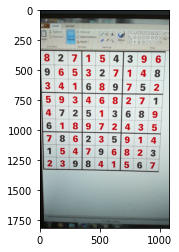

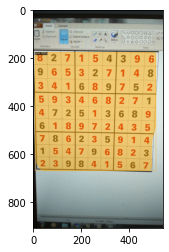

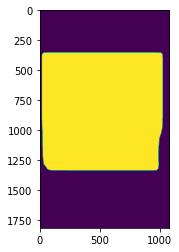

computed box: [[24, 360], [1011, 360], [48, 1301], [984, 1298]]
[9, 4, 4, 1, 5, 4, 3, 8, 4, 4, 9, 5, 3, 2, 7, 1, 4, 8, 3, 8, 8, 6, 8, 9, 7, 5, 5, 5, 9, 3, 9, 6, 8, 5, 7, 7, 4, 7, 2, 5, 7, 5, 2, 6, 6, 5, 7, 8, 2, 7, 5, 5, 5, 7, 7, 2, 5, 5, 5, 5, 5, 5, 7, 7, 5, 2, 7, 5, 7, 5, 5, 5, 5, 5, 5, 5, 7, 5, 7, 7, 5]


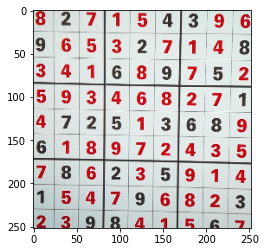

prepare: False , solve: True
board:
9 4 4|1 5 4|3 8 4|
4 9 5|3 2 7|1 4 8|
3 8 8|6 8 9|7 5 5|
-----------
5 9 3|9 6 8|5 7 7|
4 7 2|5 7 5|2 6 6|
5 7 8|2 7 5|5 5 7|
-----------
7 2 5|5 5 5|5 5 7|
7 5 2|7 5 7|5 5 5|
5 5 5|5 7 5|7 7 5|
-----------


In [ ]:
# load our example sudoku once again
im = cv2.imread("sud_example1.jpg")
plt.imshow(im)
plt.show()
# get prediction from mrcnn
outputs = predictor(im)  
v = Visualizer(im[:, :, ::-1],
                metadata=MetadataCatalog.get(catalogSet), 
                scale=0.5, 
                instance_mode=ColorMode.SEGMENTATION
  )
# show prediction
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
plt.imshow(out.get_image()[:, :, ::-1])
plt.show()

pts = outputs['instances'].pred_boxes.tensor.cpu().numpy()[0]

# box points
pts = np.int32(
    [[round(pts[0]), round(pts[1])],
     [round(pts[2]), round(pts[1])],
     [round(pts[0]), round(pts[3])],
     [round(pts[2]), round(pts[3])]]
)

# mask
mask = outputs['instances'].pred_masks.cpu()[0,:,:].numpy()
plt.imshow(mask)
plt.show()

# result points
pts2 = []

# connect box corners to mask corners
bfs = BFSFinder(mask)
for pt in pts:
  pts2.append(bfs.start(pt))
# print out new points
print("computed box:",pts2)
# these are the best values
# [[4, 339],
# [1043, 352],
# [35, 1316],
# [982, 1339]]

# call extraction image and try to solve the sudoku
ext = extractImage(im, pts2[0], pts2[1], pts2[2], pts2[3], 252)
sudoku = extractNumbers(ext)
print(sudoku)
plt.imshow(ext)
plt.show()
DEBUG = False
solver = SudokuBoard()
solver.init(sudoku)
rprepare = solver.prepare()
rsolve = solver.solve()
print("prepare:",rprepare, ", solve:", rsolve)
solver.show()

Sadly, the last row is clipped, because of the mask is no perfect at its right side, lets try to run more test on our sudoku dataset

## Attempt 2

In [34]:
# wrap previous code cell into a function
def go(sudokuFile, info = False):
  im = cv2.imread(sudokuFile)
  if info:
    plt.imshow(im)
    plt.show()
  # get prediction from mrcnn
  outputs = predictor(im)  
  v = Visualizer(im[:, :, ::-1], 
                  scale=0.5, 
                  instance_mode=ColorMode.SEGMENTATION
    )
  # show prediction
  out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
  if info:
    plt.imshow(out.get_image()[:, :, ::-1])
    plt.show()

  pts = outputs['instances'].pred_boxes.tensor.cpu().numpy()[0]

  # box points
  pts = np.int32(
      [[round(pts[0]), round(pts[1])],
       [round(pts[2]), round(pts[1])],
       [round(pts[0]), round(pts[3])],
       [round(pts[2]), round(pts[3])]]
  )

  # mask
  mask = outputs['instances'].pred_masks.cpu()[0,:,:].numpy()
  if info:
    plt.imshow(mask)
    plt.show()

  # result points
  pts2 = []

  # connect box corners to mask corners
  bfs = BFSFinder(mask)
  for pt in pts:
    pts2.append(bfs.start(pt))

  # call extraction image and try to solve the sudoku
  ext = extractImage(im, pts2[0], pts2[1], pts2[2], pts2[3], 252)
  sudoku = extractNumbers(ext, info)
  if info:
    print(sudoku)
    plt.imshow(ext)
    plt.show()
  DEBUG = False
  solver = SudokuBoard()
  solver.init(sudoku)
  rprepare = solver.prepare()
  if not rprepare:
    return False, False
  rsolve = solver.solve()
  return rprepare, rsolve

In [39]:
# try to probe the test dataset
data = DatasetCatalog.get("mrcnnTest")

okp = 0
oks = 0
total = 0

for d in data:
  prep, solved = go(d['file_name'])
  total+=1
  if total % 30 == 0:
    print(total,"done")
  if prep:
    okp += 1
  if prep and solved:
    oks += 1


print("total:", total, "successfully prepared:",okp, "successfully solved:",oks)


[01/18 20:48:58 d2.data.datasets.coco]: Loaded 40 images in COCO format from mrcnnTest/labels.json
30 done
total: 40 successfully prepared: 0 successfully solved: 0


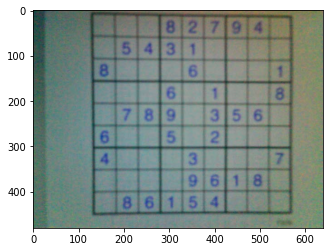

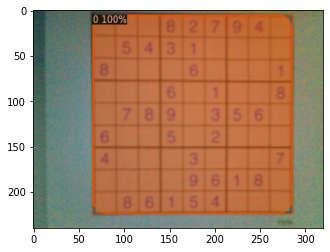

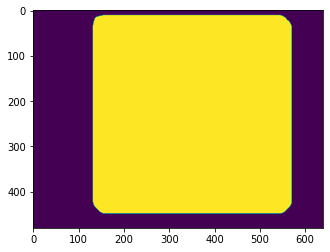

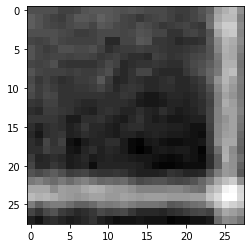

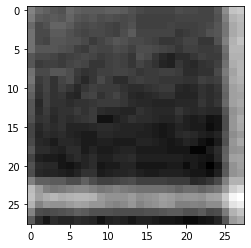

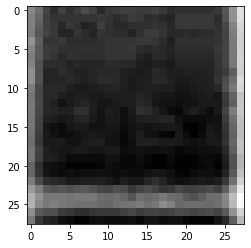

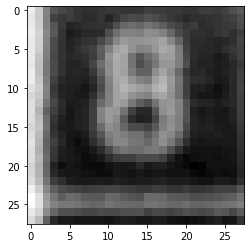

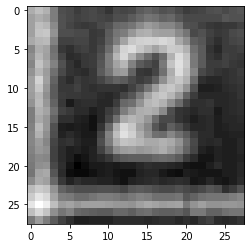

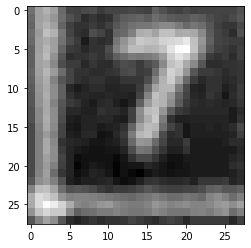

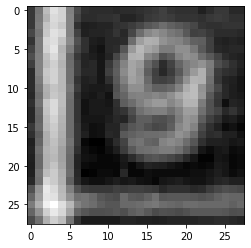

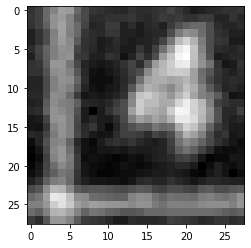

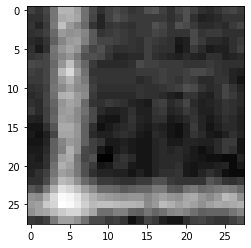

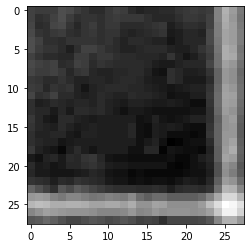

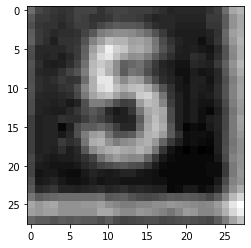

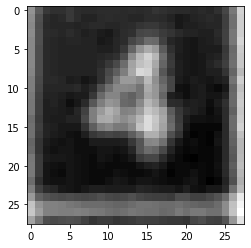

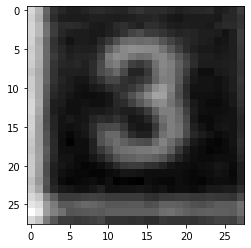

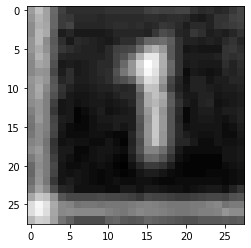

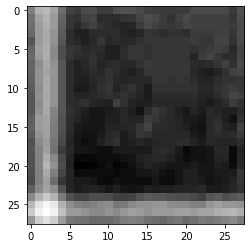

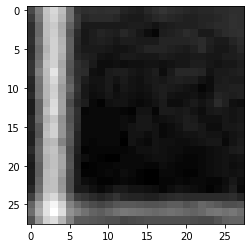

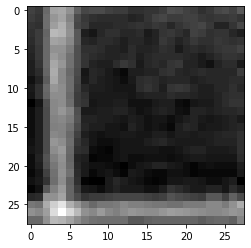

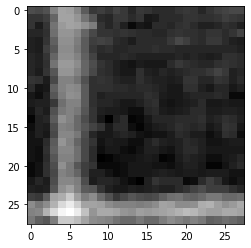

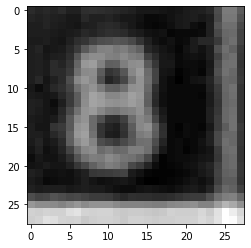

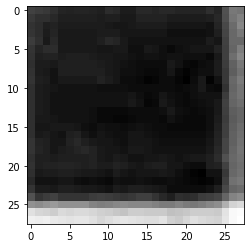

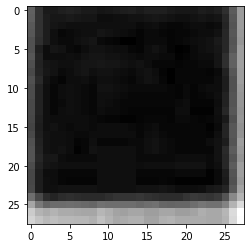

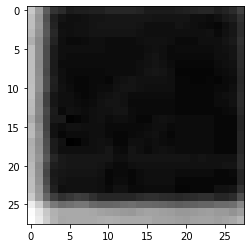

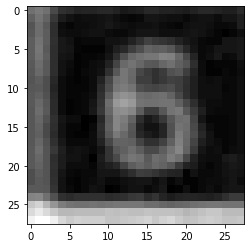

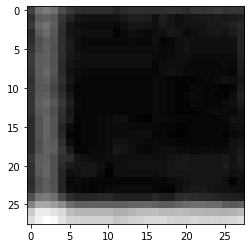

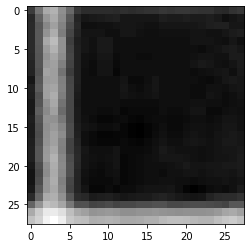

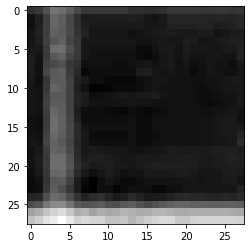

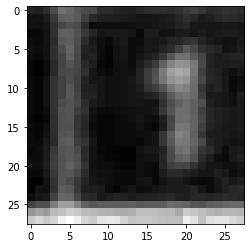

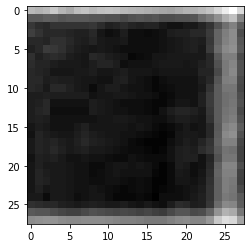

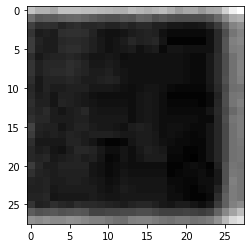

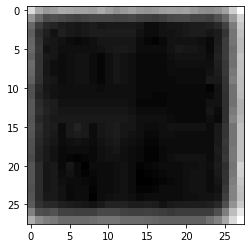

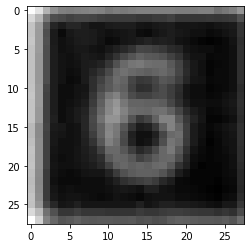

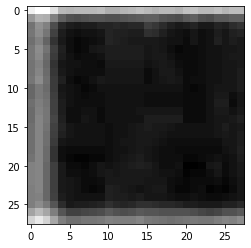

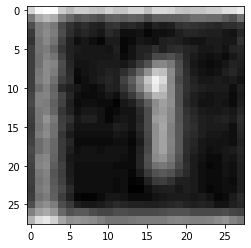

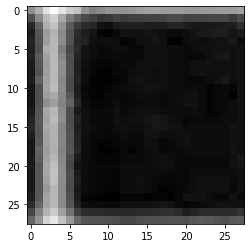

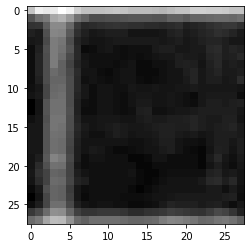

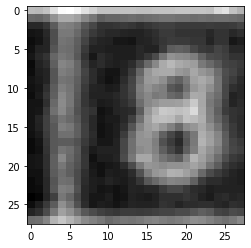

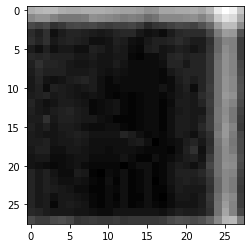

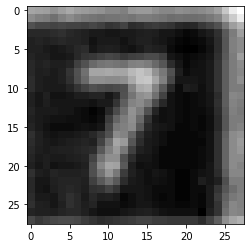

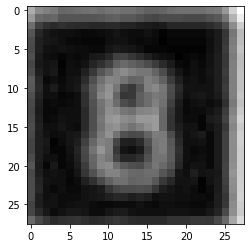

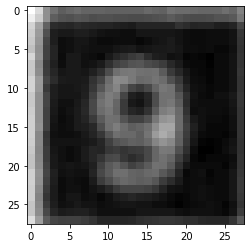

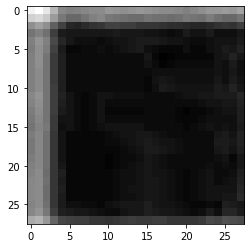

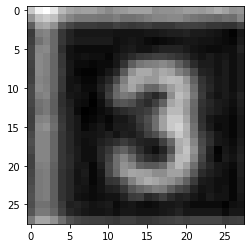

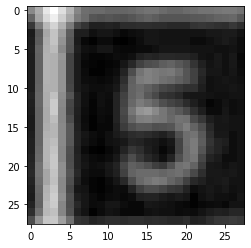

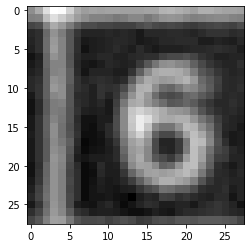

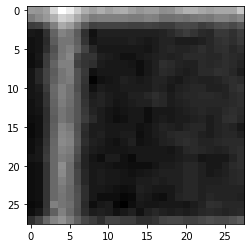

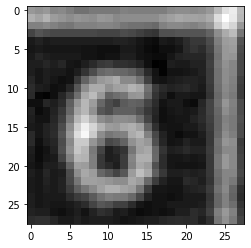

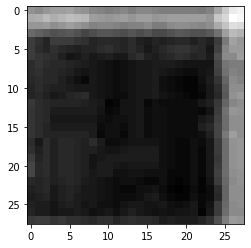

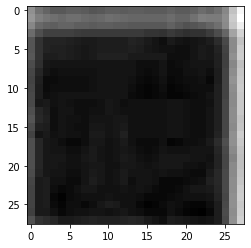

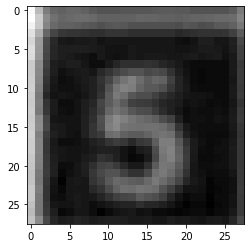

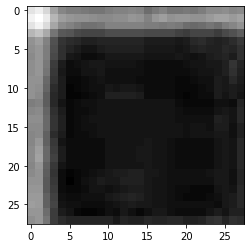

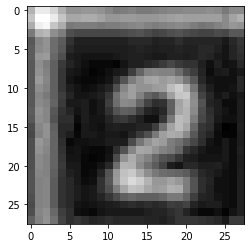

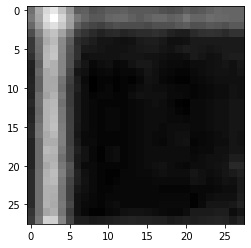

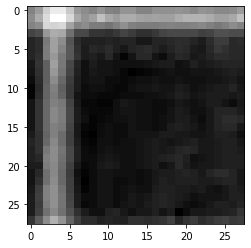

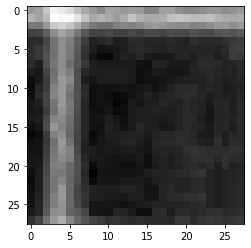

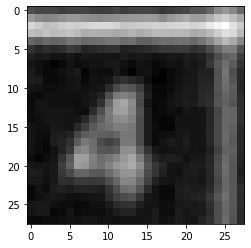

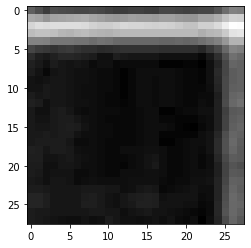

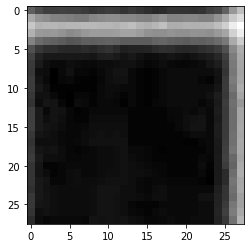

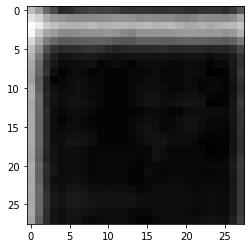

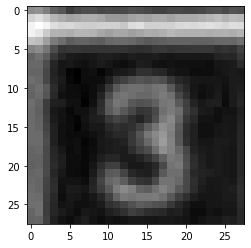

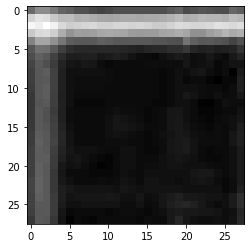

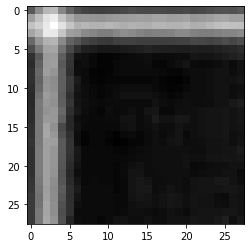

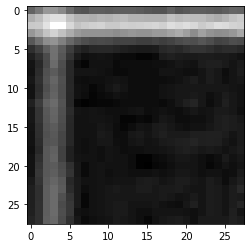

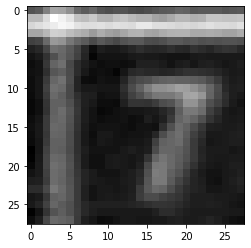

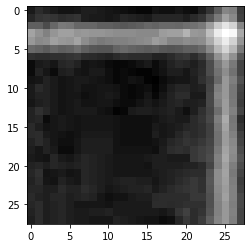

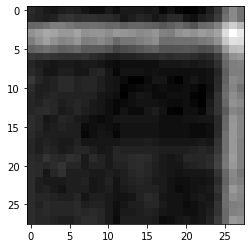

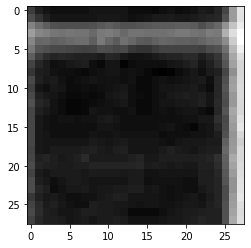

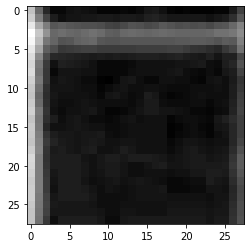

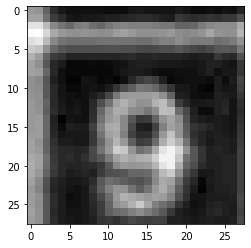

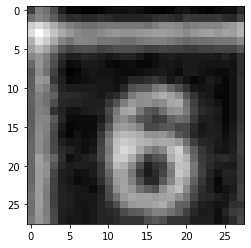

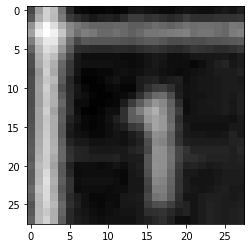

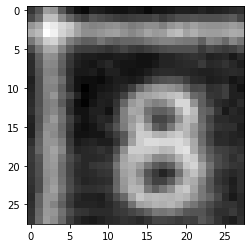

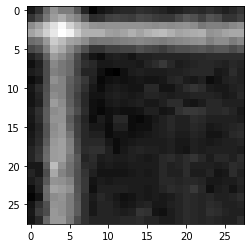

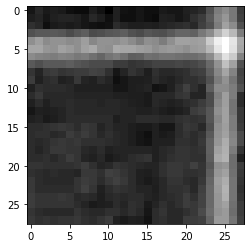

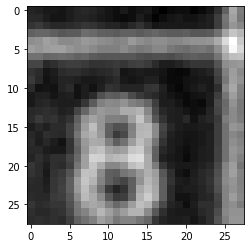

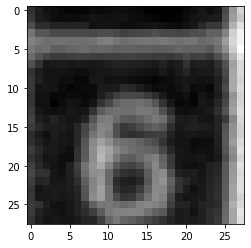

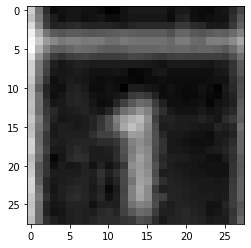

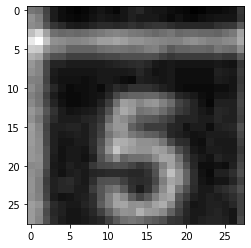

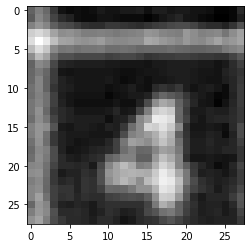

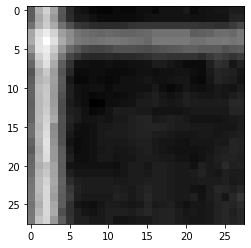

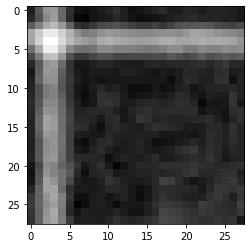

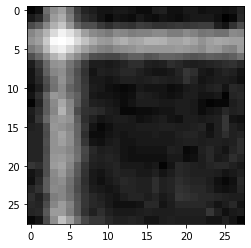

[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 8, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]


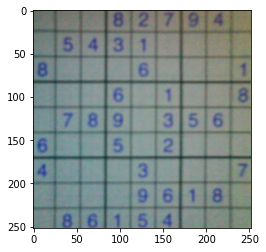

(False, False)

In [38]:
# try random image with a "debug look"
go("mrcnnTest/image46.jpg", True)

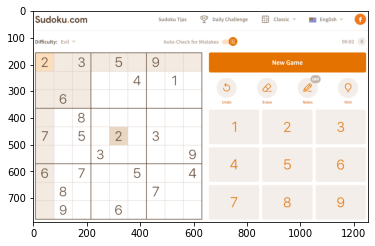

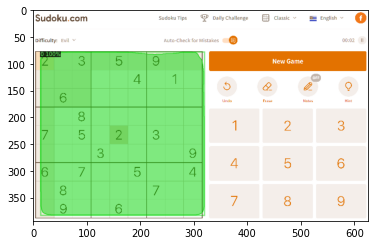

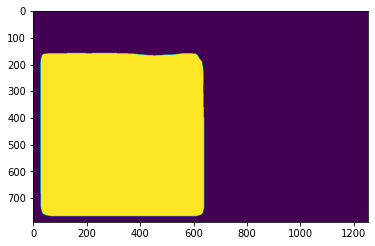

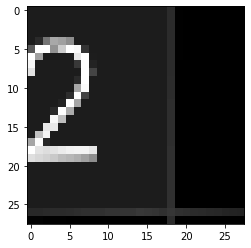

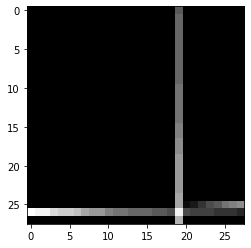

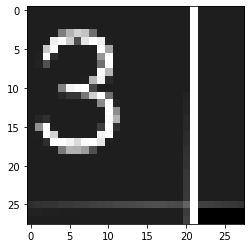

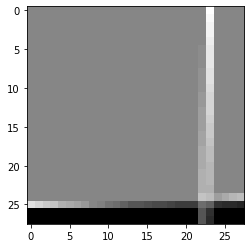

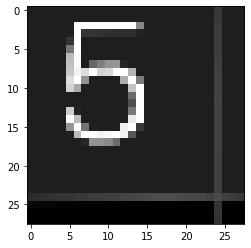

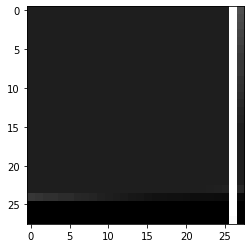

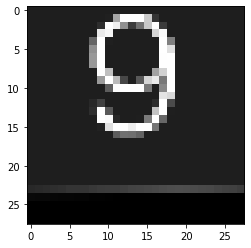

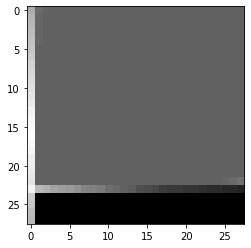

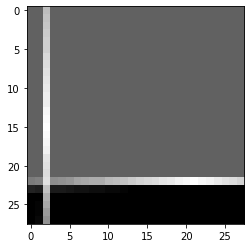

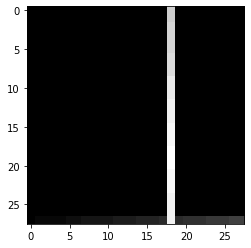

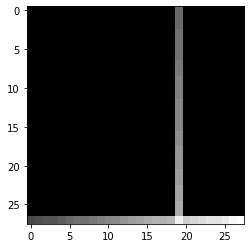

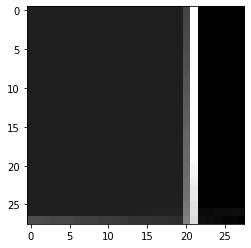

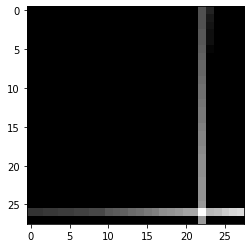

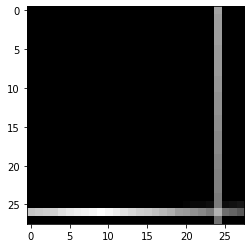

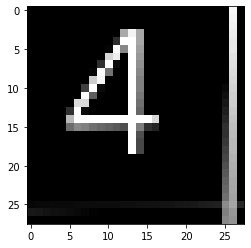

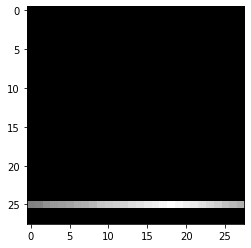

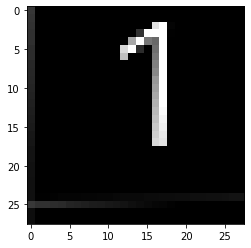

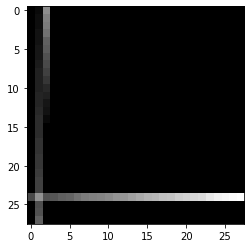

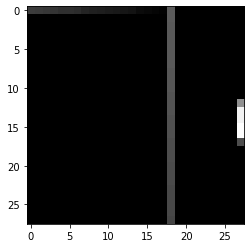

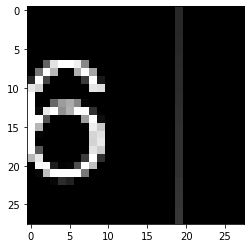

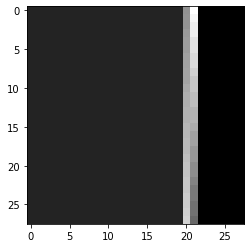

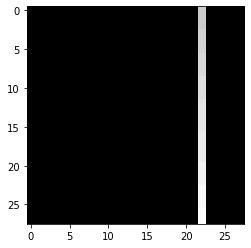

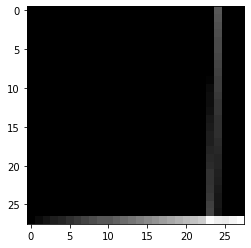

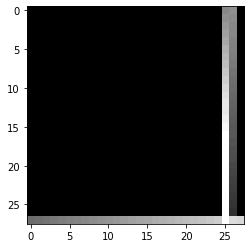

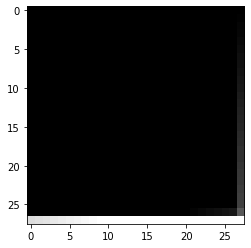

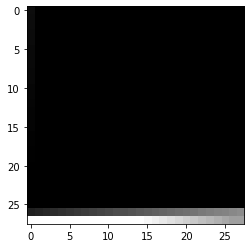

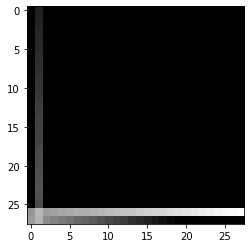

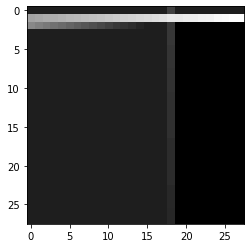

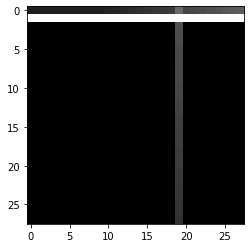

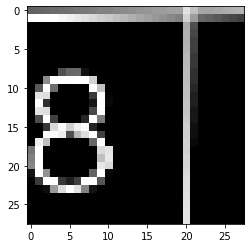

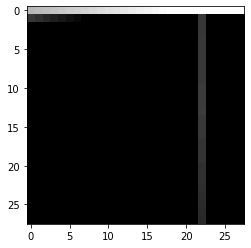

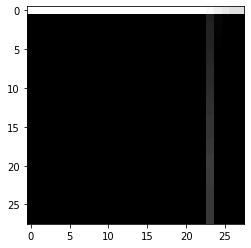

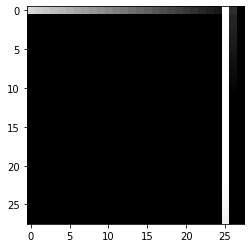

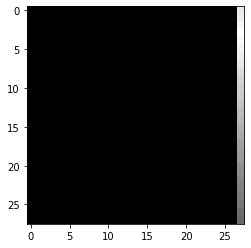

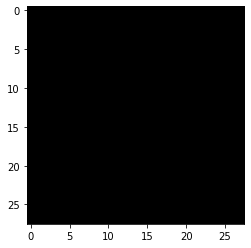

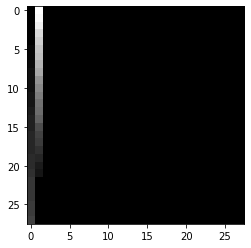

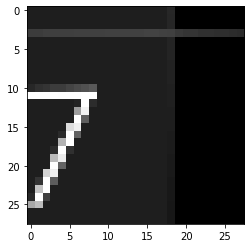

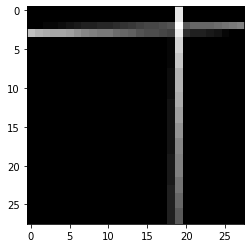

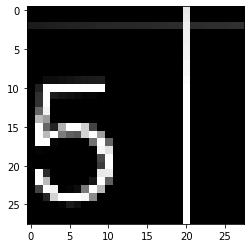

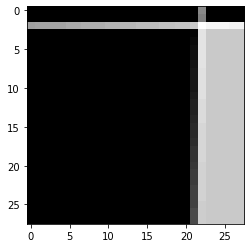

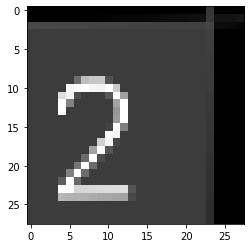

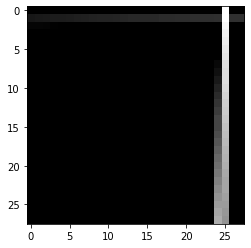

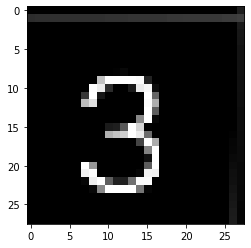

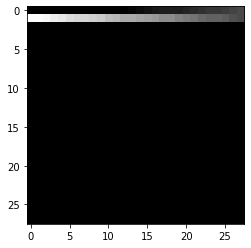

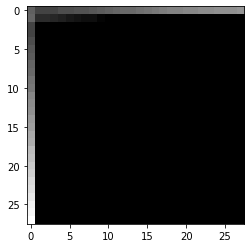

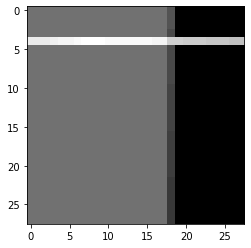

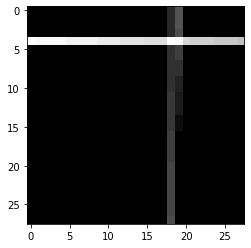

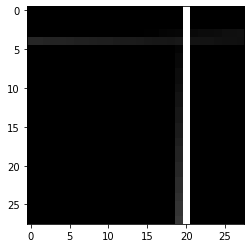

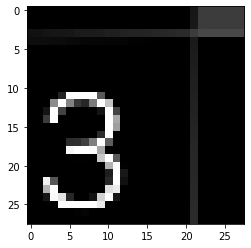

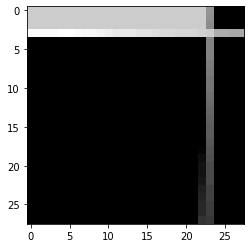

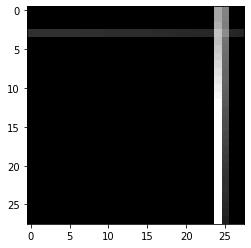

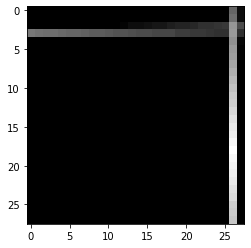

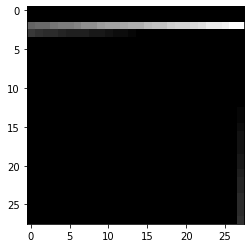

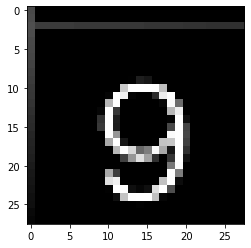

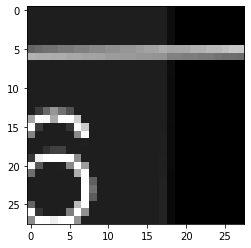

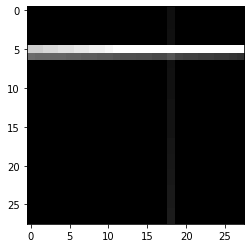

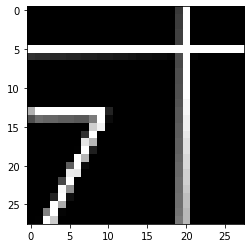

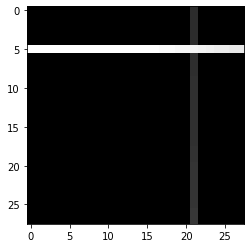

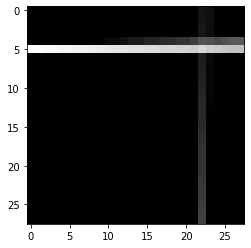

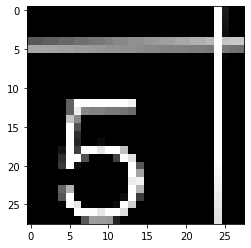

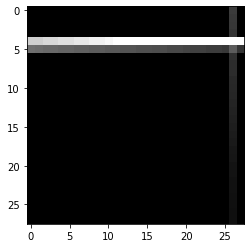

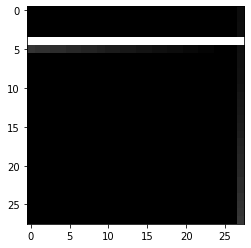

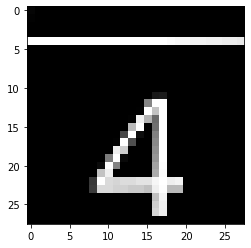

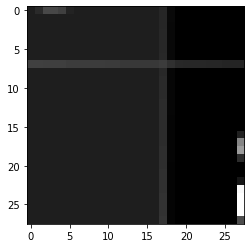

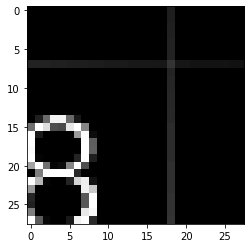

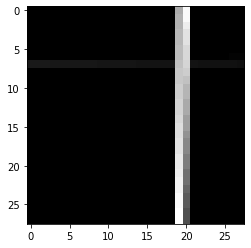

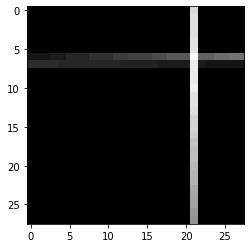

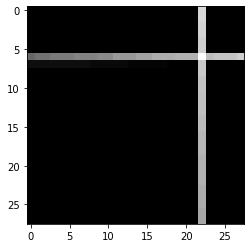

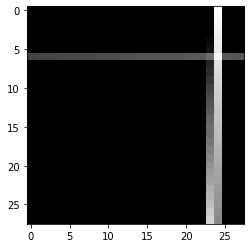

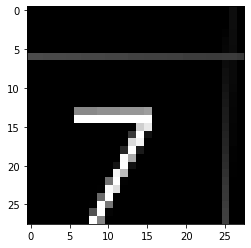

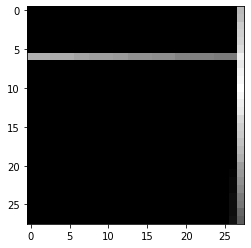

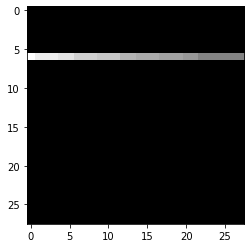

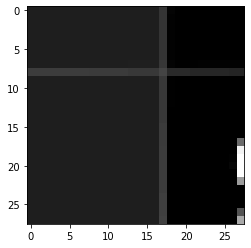

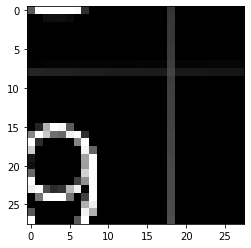

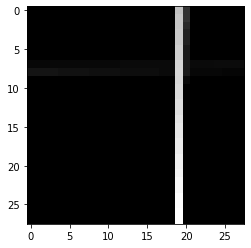

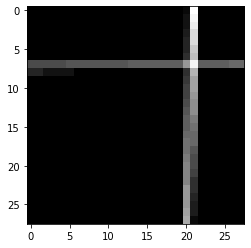

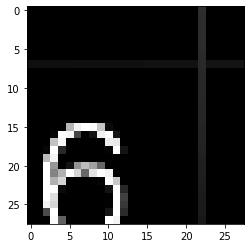

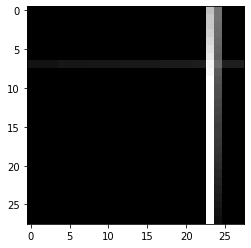

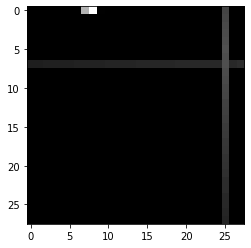

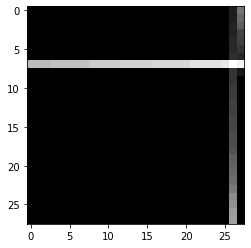

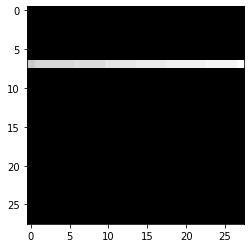

[4, 0, 4, 0, 9, 8, 7, 8, 8, 0, 0, 4, 0, 0, 4, 0, 7, 0, 0, 8, 4, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 7, 0, 8, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 5, 0, 7, 0, 0, 5, 0, 0, 5, 0, 0, 0, 0, 0, 7, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


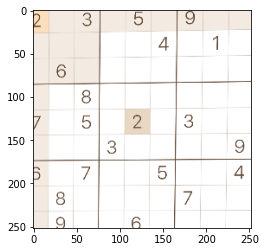

(False, False)

In [37]:
# try one more custom image
go("sud_example3.png", True)

In [ ]:
# wrap it up with a sad face